In [ ]:
#!pip install seaborn

In [ ]:
#!pip install sklearn

In [1]:
import os
import pickle
import tensorflow as tf
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib
from PIL import Image
import matplotlib.pyplot as plt
from config import Configuration
from values import *
from results import load_losses, load_scores, load_captions
from steps.step1b_mscoco import load_test_images
from steps.step4_text_processor import process_text, process_captions, sequence_generator, get_text_vectors
from steps.step5_vgg_model import load_func
from models.model import CaptionModel
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.image as mpimg

In [ ]:
#coco_adam_rglz_50_epoch
model_names = ["coco_sgd_rglz_effi_def", "1112-1010_witsgdrglzeff"]

In [57]:
# using no regularization and default model size, lr = 0.001 adam
# folders 1812-22-22-44_coco_adam_no_rglz_efficientnet_80000_default_emb
# and 1812-22-22-05_coco_adam_no_rglz_inception_v3_80000_default_emb
model_names = ["_result_coco_adam_no_rglz_inc_default_emb", "_result_coco_adam_no_rglz_eff_default_emb"]
                
# model with low learning rate, 0.0002
# 256-or-glove x 128 x 256, using 0.01 L1 reg and 0.3 dropout:
# folder: 1912-09-09-48_coco_adam_rglz_inception_v3_80000_default_emb and
# 1912-12-12-45_coco_adam_rglz_inception_v3_80000_glove_emb
model_names = ["_result_coco_adam_regl_128x256x128", "_result_coco_adam_regl_glovex256x128"]

# scaled out
model_names = ["_result_scale_out_coco", "_result_scale_out_wit"]

In [58]:
root_folder = "E:\WIT_10pct"
base_folder = os.path.join(root_folder, 'train')
model_folders = [os.path.join(base_folder, model_name) for model_name in model_names]
npy_folder = 'npy_files_efficientnet_coco_-1'
val_imgs = os.path.join(root_folder, 'val2014')

In [7]:
values['dataset'] = 'WIT'
cfg = Configuration(**values)

text_captions, filtered_df, images_folder, validation_folder = process_text(cfg)
text_captions, caption_len = process_captions(text_captions)
tokenized_caps = [sent.split() for sent in text_captions]
vocab, vectorizer = get_text_vectors(cfg, text_captions, caption_len)
text_captions = sequence_generator(text_captions, vectorizer)

lengths_wit = np.array([len(seq) for seq in tokenized_caps])

values['dataset'] = 'COCO'
cfg = Configuration(**values)

text_captions, filtered_df, images_folder, validation_folder = process_text(cfg)
text_captions, caption_len = process_captions(text_captions)
tokenized_caps = [sent.split() for sent in text_captions]
vocab, vectorizer = get_text_vectors(cfg, text_captions, caption_len)
text_captions = sequence_generator(text_captions, vectorizer)

lengths_coco = np.array([len(seq) for seq in tokenized_caps])

In [8]:
filtered_df["seq_len"] = filtered_df["page_title"].apply(len)

In [59]:
filtered_df.head()

page_title   type  \
0  <START> cat standing by some cabinets in room ...  train   
1  <START> man begins snowboard trip while two pe...  train   
2  <START> beer and pizza slice sitting in pizza ...  train   
3  <START> there is no one else in the photo exce...  train   
4  <START> basket with onion rings coleslaw and s...  train   

                             image  seq_len  
0  COCO_train2014_000000283617.jpg       51  
1  COCO_train2014_000000262335.jpg       78  
2  COCO_train2014_000000287872.jpg       73  
3  COCO_train2014_000000538003.jpg       68  
4  COCO_train2014_000000294688.jpg       65

In [60]:
'''
embedding_dim = 256
units = 512
model, ckpt_manager, start_epoch = CaptionModel.load_or_init(embedding_dim, units, vectorizer, cfg, model_folder)
'''

'\nembedding_dim = 256\nunits = 512\nmodel, ckpt_manager, start_epoch = CaptionModel.load_or_init(embedding_dim, units, vectorizer, cfg, model_folder)\n'

In [61]:
def get_losses(model_folder, max_epoch = None):
    loss = load_losses(model_folder)
    scores = np.array(load_scores(model_folder))
    train_loss = loss[0][0:]
    t_loss = [float(lv) for lv in train_loss]

    val_loss = loss[1][0:]
    v_loss = [float(lv) for lv in val_loss]

    epoch = [j+1 for j in range(0, len(t_loss))]
    if max_epoch:
        epoch = epoch[:max_epoch]
        t_loss = t_loss[:max_epoch]
        v_loss = v_loss[:max_epoch]
    
    return t_loss, v_loss, epoch

def get_scores(model_folder):
    scores = load_scores(model_folder)
    epochs = [i for i in range(0, len(scores)*5, 5)]    
    return scores, epochs    

In [62]:
model_folders

['E:\\WIT_10pct\\train\\_result_scale_out_coco',
 'E:\\WIT_10pct\\train\\_result_scale_out_wit']

In [68]:
a = load_captions(cfg, model_folders[1], 15)

loading E:\WIT_10pct\train\_result_scale_out_wit\preds_epoch_15.lst
(2,)


In [ ]:
predictions

In [111]:
predictions = None
predictions, predictions_train, val_df = load_captions(cfg, model_folders[1], 40)
file_names = [os.path.basename(pred[0]) for pred in predictions]
for i, name in enumerate(file_names):
    real_cap = val_df[val_df['image'] == name]['page_title'].values.tolist()
    predictions[i].append(real_cap)

loading E:\WIT_10pct\train\_result_scale_out_wit\preds_epoch_40.lst
(2,)


In [112]:
model_folders[0]

'E:\\WIT_10pct\\train\\_result_scale_out_coco'

In [118]:
with open(os.path.join(model_folders[1], 'preds_epoch_30.lst'), 'rb') as pickle_file:
    predictions = pickle.load(pickle_file)

In [119]:
predictions

([(<tf.Tensor: shape=(), dtype=string, numpy=b'/cluster/work/larshanu/ic/npy_files_efficientnet_wit_-1/f5717093-c952-430f-aa8b-51fd9ee5d0c9.jpg'>,
   ['white', 'creek', 'branch', 'state', 'committee'],
   array([[2.36632139e-03, 3.31577212e-01, 1.53910266e-02, ...,
           6.74349591e-02, 4.42828275e-02, 1.89391576e-04],
          [8.59410095e-04, 3.50509770e-03, 4.47054058e-01, ...,
           2.98024333e-05, 7.98361070e-05, 1.25445354e-07],
          [2.21734401e-03, 5.65441921e-02, 8.40869543e-05, ...,
           2.52612382e-01, 1.17245493e-02, 2.17331643e-03],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])),
  (<tf.Tensor: shape=(), dtype=strin

wit is in the path ['/cluster/work/larshanu/ic/npy_files_efficientnet_wit_-1/443cb9f5-4505-4a0a-beab-7c7886f9928b.jpg', ['list', 'of', 'cricketers', 'who', '[UNK]', '[UNK]'], array([[4.00506658e-03, 2.59284265e-02, 1.73701853e-01, ...,
        1.42471492e-03, 1.39233610e-02, 1.67115613e-05],
       [5.64694889e-02, 1.78009346e-02, 5.23245952e-04, ...,
        8.85037631e-02, 4.67019156e-03, 6.63785971e-10],
       [8.12089965e-02, 1.45737808e-02, 1.56826180e-04, ...,
        3.14073041e-02, 1.98832244e-01, 1.17146251e-10],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]), []]


IndexError: list index out of range

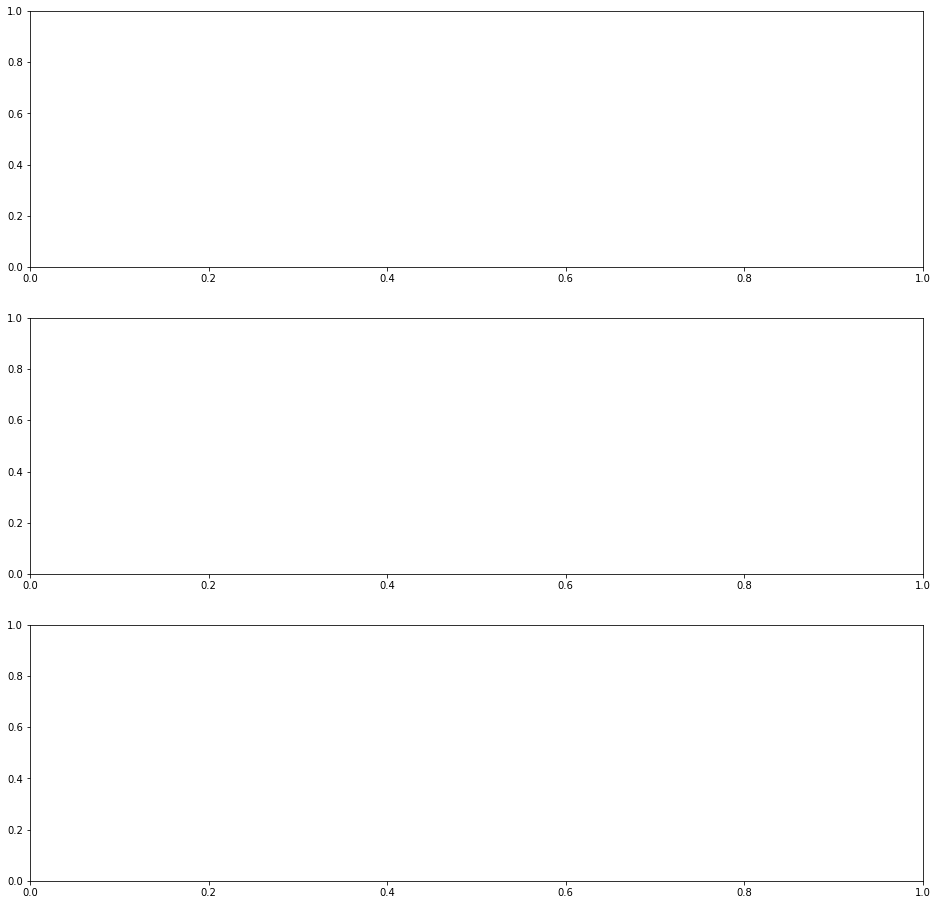

In [109]:
# show the images, and their captions
w = 200
h = 200

fig, ax = plt.subplots(3,1, figsize=(16,16))
columns = 3
rows = 1
for i in range(0, 3):
    index = i
    img_path = predictions[index][0]
    if "wit" in img_path:
        print("wit is in the path", predictions[index])
        img_path = img_path.replace("/cluster/work/larshanu/ic/npy_files_efficientnet_wit_-1/", "E:\\WIT_10pct\\images\\")
    #img = Image.open(img_path)
    #img = img.resize((w, h))        
    predicted_string = f'Predicted: {(" ".join(predictions[index][1]))} \n\n Human written: {predictions[index][3][0]}\n'    
    ax[i].imshow(img)
    ax[i].set_title(predicted_string, wrap=True)
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
fig.tight_layout(pad=7.0)

plt.show()

In [ ]:
predictions

#### Loss DataFrames

In [135]:

m1_t_loss, m1_v_loss, m1_epoch = get_losses(model_folders[0], 50)
m2_t_loss, m2_v_loss, m2_epoch = get_losses(model_folders[1], 50)

m1_t_data = {'m1_loss': m1_t_loss, 'm1_epoch': m1_epoch}
m1_v_data = {'m1_loss': m1_v_loss, 'm1_epoch': m1_epoch}
m1_loss_df = pd.DataFrame(m1_t_data)
m1_val_loss_df = pd.DataFrame(m1_v_data)

m2_t_data = {'m2_loss': m2_t_loss, 'm2_epoch': m2_epoch}
m2_v_data = {'m2_loss': m2_v_loss, 'm2_epoch': m2_epoch}
m2_loss_df = pd.DataFrame(m2_t_data)
m2_val_loss_df = pd.DataFrame(m2_v_data)

#### Score DataFrames

In [136]:
val = 0
train = 1

score_to_use = val

scores1, score_epochs1 = get_scores(model_folders[0])
scores2, score_epochs2 = get_scores(model_folders[1])

scores_df1 = pd.DataFrame([s[score_to_use] for s in scores1], columns=["bleu1", "bleu2", "bleu3", "bleu4", "meteor"])
scores_df1 = scores_df1.assign(epoch=score_epochs1) 

scores_df2 = pd.DataFrame([s[score_to_use] for s in scores2], columns=["bleu1", "bleu2", "bleu3", "bleu4", "meteor"])
scores_df2 = scores_df2.assign(epoch=score_epochs2) 

In [137]:
m2_val_loss_df.tail(10)

m2_loss  m2_epoch
31  4.496027        32
32  4.533734        33
33  4.531140        34
34  4.688494        35
35  4.694210        36
36  4.612267        37
37  4.668198        38
38  4.837437        39
39  4.891277        40
40  4.879725        41

In [138]:
scores_df1.head()

bleu1     bleu2     bleu3     bleu4    meteor  epoch
0  0.052019  0.011680  0.002249  0.001011  0.099502      0
1  0.092551  0.027662  0.006439  0.000635  0.161625      5
2  0.120553  0.042823  0.012206  0.003323  0.201361     10
3  0.117400  0.044688  0.013566  0.003384  0.208109     15
4  0.143851  0.051872  0.017515  0.004101  0.219969     20

In [139]:
scores_df2.tail()

bleu1     bleu2     bleu3     bleu4    meteor  epoch
4  0.303105  0.262408  0.159630  0.073939  0.292232     20
5  0.358378  0.324468  0.227227  0.100387  0.347930     25
6  0.372320  0.329389  0.231133  0.104379  0.359150     30
7  0.424995  0.390099  0.287208  0.123701  0.413114     35
8  0.445137  0.409631  0.297622  0.131354  0.432311     40

In [140]:
m1_val_loss_df.tail()

m1_loss  m1_epoch
45  1.454574        46
46  1.465347        47
47  1.471581        48
48  1.469758        49
49  1.483688        50

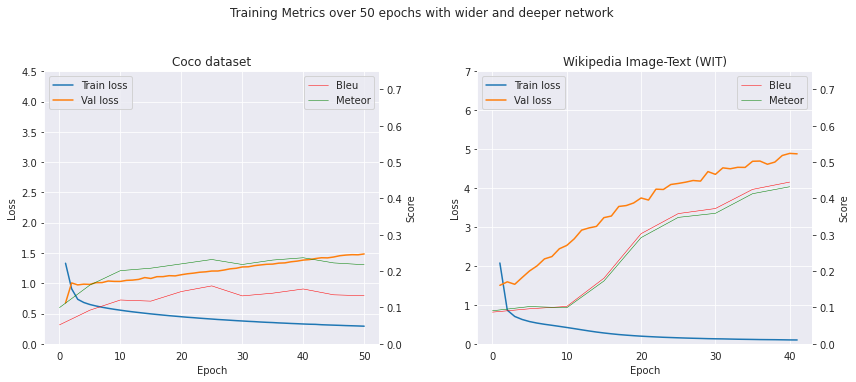

In [141]:
lrs = ["Coco dataset", "Wikipedia Image-Text (WIT)"]
with sns.axes_style("darkgrid"):    
    #sns.set_style("ticks",{'axes.grid' : True})
    f, ax = plt.subplots(1, 2, figsize=(13, 6))
    f.tight_layout(pad=7.0)
    ax1 = ax[0]
    ax2 = ax[1]
    
    ax1.set(xlabel="Epoch", ylabel="Loss", ylim=(0, 4.5), title=lrs[0])
    #ax1.set_yticks([i/4 for i in range(10)])
    ax1.set_axisbelow(True)
    
    ax2.set(xlabel="Epoch", ylabel="Loss", ylim=(0, 7), title=lrs[1])    
    #ax2.set_yticks([i/4 for i in range(10)])
    ax2.set_axisbelow(True)
    
    # Dataset1
    loss_plot = sns.lineplot(x="m1_epoch", y="m1_loss", ax=ax1 , data=m1_loss_df, label="Train loss")
    val_plot = sns.lineplot(x="m1_epoch", y="m1_loss", ax=ax1, data=m1_val_loss_df, label="Val loss")
    
    # Dataset2
    loss_plot_m2 = sns.lineplot(x="m2_epoch", y="m2_loss", ax=ax2, data=m2_loss_df, label="Train loss")
    val_plot_m2 = sns.lineplot(x="m2_epoch", y="m2_loss", ax=ax2, data=m2_val_loss_df, label="Val loss")
    
    # Dataset1    
    score_ax1 = ax1.twinx()
    score_ax1.set_axisbelow(True)
    score_ax1.set(ylim=(0, 0.75), ylabel="Score")
    #score_ax1.set_yticks([i/10 for i in range(10)])
    bleu1_plt1 = sns.lineplot(x="epoch", y="bleu1", linewidth=.5, ax=score_ax1, color='red', data=scores_df1, label="Bleu")
    #bleu1_plt2 = sns.lineplot(x="epoch", y="bleu2", linewidth=.5, ax=score_ax1, color='purple', data=scores_df1, label="Bleu-2")
    meteor_plt1 = sns.lineplot(x="epoch", y="meteor", linewidth=.5, ax=score_ax1, color='green', data=scores_df1, label="Meteor")
    
    # Dataset2    
    score_ax2 = ax2.twinx()
    score_ax2.set_axisbelow(True)
    #score_ax2.set_yticks([i/10 for i in range(10)])
    score_ax2.set(ylim=(0, 0.75), ylabel="Score")
    bleu1_plt2 = sns.lineplot(x="epoch", y="bleu1", linewidth=.5, ax=score_ax2, color='red', data=scores_df2, label="Bleu")
    #bleu2_plt2 = sns.lineplot(x="epoch", y="bleu2", linewidth=.5, ax=score_ax2, color='purple', data=scores_df2, label="Bleu-2")
    meteor_plt2 = sns.lineplot(x="epoch", y="meteor", linewidth=.5, ax=score_ax2, color='green', data=scores_df2, label="Meteor")    
    
    score_ax2.grid(False)
    score_ax1.grid(False)

    f.suptitle(f"Training Metrics over {len(m1_epoch)} epochs with wider and deeper network")
    sns.move_legend(ax1, "upper left")
    sns.move_legend(ax2, "upper left")


In [ ]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
sns.set()
with sns.axes_style("darkgrid"):
    dist = sns.distplot(lengths_coco, bins=30, kde_kws={'bw': 0.3}, ax=ax1)
    dist = sns.distplot(lengths_wit, bins=30, kde_kws={'bw': 0.3}, ax=ax2)
    ax1.set(xlim=(0, 25), xlabel="Caption length", title="Coco Dataset")
    ax2.set(xlim=(0, 25), xlabel="Caption length", title="Wikipedia Image-Text (WIT)")
    ax1.set(xlim=(0, 25))
    ax2.set(xlim=(0, 25))
f.suptitle(f"Caption length density for the two datasets")

In [ ]:
test_folder = 'train2014'

In [ ]:
test_images = load_test_images(cfg, test_folder, amt=3)
print(test_images)
numpy_files = [f"{os.path.join(cfg.root, npy_folder, im.split('.')[0]+'.npy')}" for im in test_images]
caps = [np.random.rand(1,5) for n in numpy_files]
dataset = tf.data.Dataset.from_tensor_slices((test_images, numpy_files, caps)).map(lambda item0, item1, item2: tf.numpy_function(
            load_func, [item0, item1, item2], [tf.string, tf.float32, tf.int32]),
                                num_parallel_calls=tf.data.AUTOTUNE).batch(1)

In [ ]:
vocabulary = vectorizer.get_vocabulary()
len(vocabulary)

In [ ]:
for b, (img, npy, cap) in enumerate(dataset):
    npy = tf.squeeze(npy, axis=0)
    print(img, npy.shape)
    preds, att_plots = model.evaluate(npy, 50)
    print(preds)

In [ ]:
npy_files = os.listdir(os.path.join(cfg.root, npy_folder))
images = [f"{cfg.root}\\{f.split('.')[0]}.jpg"]